<a href="https://colab.research.google.com/github/thomas-greig/MSc/blob/main/Multi%26add_NN_ani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

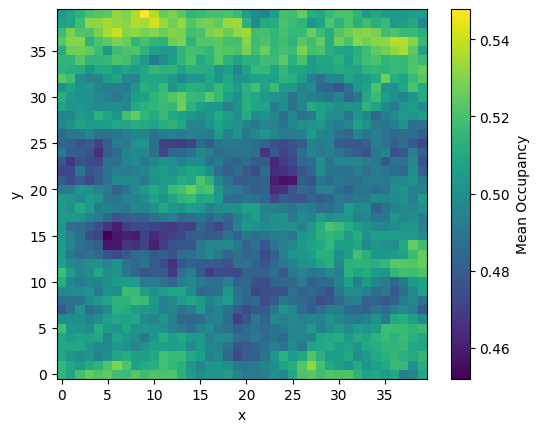

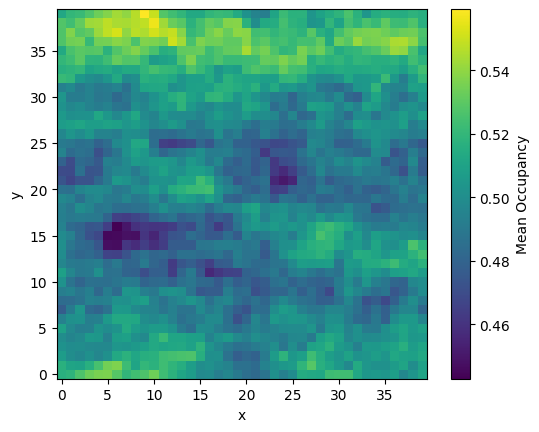

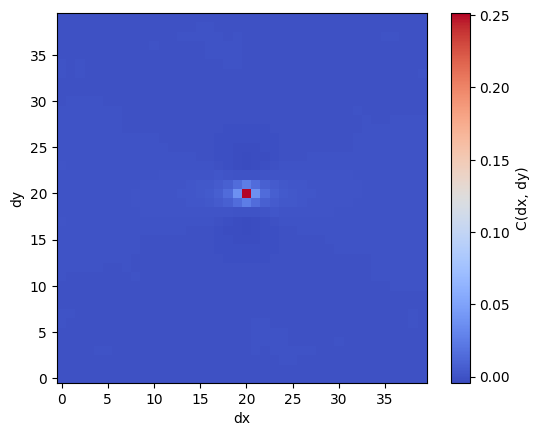

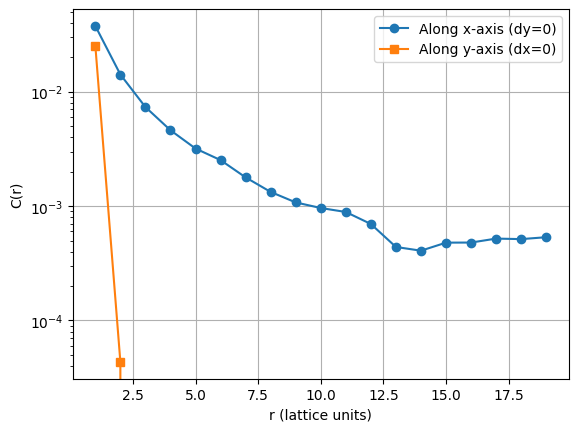

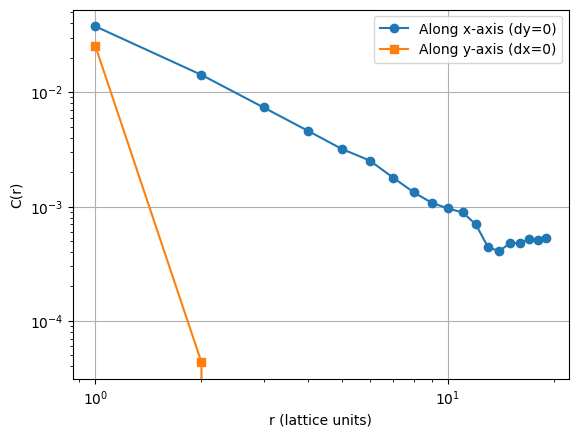

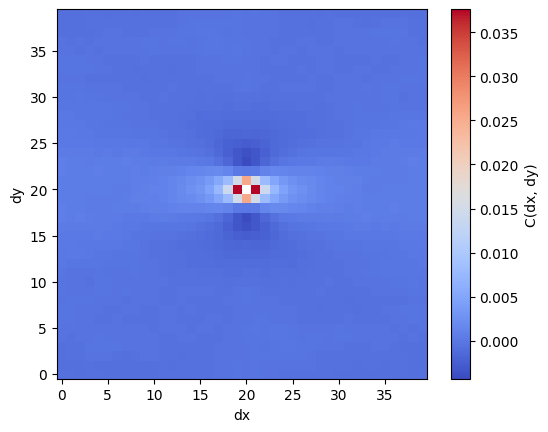

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
Lx, Ly = 40, 40
N = 800
steps = 15_000_000
b_over_T = 4.0          # β/T
J_over_T = b_over_T/3.0  # J/T
eps = 0.8
drift_direction = (1, 0)
sample_every = 600
relaxation_index = int(0.2 * steps / sample_every)

# === Initialise randomly ===
positions = np.column_stack((
    np.random.randint(0, Lx, size=N),
    np.random.randint(0, Ly, size=N)
))
occupancy = np.zeros((Lx, Ly), dtype=int)
for x, y in positions:
    occupancy[x, y] += 1

# --- helpers for NN sums on a periodic lattice ---
nn_disps = [(-1,0),(1,0),(0,-1),(0,1)]
def nn_sum(occ, x, y):
    s = 0
    for dx,dy in nn_disps:
        s += occ[(x+dx) % Lx, (y+dy) % Ly]
    return s
def are_nn(x1,y1,x2,y2):
    # periodic Manhattan distance 1?
    return ((x1 - x2) % Lx in (1, Lx-1) and y1 == y2) or ((y1 - y2) % Ly in (1, Ly-1) and x1 == x2)

# === Sigmoid-based move rule with directional bias + NN attraction ===
def compute_2D_move_probabilities(positions, idx, occupancy, Lx, Ly,b_over_T, J_over_T, eps, drift_direction):
    moves = [(-1, 0), (1, 0), (0, 0), (0, 1), (0, -1)]  # L, R, S, U, D
    weights = []

    def sigmoid(x): return 1.0 / (1.0 + np.exp(x))
    dx_bias, dy_bias = drift_direction
    x_old, y_old = positions[idx]

    n_old = occupancy[x_old, y_old]
    S_old = nn_sum(occupancy, x_old, y_old)

    for dx, dy in moves:
        if dx == 0 and dy == 0:
            # stay-put: no change in configuration => ΔE = 0, no drive
            dE = 0.0
        else:
            x_trial = (x_old + dx) % Lx
            y_trial = (y_old + dy) % Ly

            n_trial = occupancy[x_trial, y_trial]
            S_trial = nn_sum(occupancy, x_trial, y_trial)

            # NN hop => indicator = 1
            dE_on = 2.0 * b_over_T * (1 + n_trial - n_old)
            dE_nn = - J_over_T * (S_trial - S_old - 1)
            drive = -(dx * dx_bias + dy * dy_bias)

            dE = dE_on + dE_nn + drive

        base_prob = sigmoid(dE)
        drift_alignment = dx * dx_bias + dy * dy_bias  # 0 for stay
        weight = (1 + eps * drift_alignment) * base_prob
        weights.append(weight)

    weights = np.asarray(weights, dtype=float)
    probs = weights / np.sum(weights)
    return probs, moves


# === 2D Spatial Correlation ===
def compute_2D_correlation(data):
    from numpy.fft import fft2, ifft2, fftshift
    T, Lx, Ly = data.shape
    mean_n = data.mean(axis=0)
    fluct = data - mean_n
    corr_fft = np.zeros((Lx, Ly), dtype=np.complex128)
    for frame in fluct:
        f = fft2(frame)
        corr_fft += f * np.conj(f)
    corr = np.real(ifft2(corr_fft)) / (T * Lx * Ly)
    corr = fftshift(corr)
    return corr

def plot_directional_cuts(corr, log_log=False):
    Lx, Ly = corr.shape
    cx, cy = Lx // 2, Ly // 2
    cut_x = corr[cx:, cy];  r_x = np.arange(0, len(cut_x))
    cut_y = corr[cx, cy:];  r_y = np.arange(0, len(cut_y))
    plt.figure()
    plt.plot(r_x[1:], cut_x[1:], 'o-', label='Along x-axis (dy=0)')
    plt.plot(r_y[1:], cut_y[1:], 's-', label='Along y-axis (dx=0)')
    if log_log:
        plt.xscale('log')
        plt.yscale('log')
    else:
        plt.yscale('log')
    plt.xlabel('r (lattice units)'); plt.ylabel('C(r)')
    plt.legend(); plt.grid(True); plt.show()

# === Run Simulation ===
n_samples = steps // sample_every + 1
occupancy_time_series = np.zeros((n_samples, Lx, Ly), dtype=int)
sample_index = 0

for t in range(steps):
    idx = np.random.randint(N)
    probs, moves = compute_2D_move_probabilities(
        positions, idx, occupancy, Lx, Ly, b_over_T, J_over_T, eps, drift_direction
    )
    dx, dy = moves[np.random.choice(len(moves), p=probs)]
    x_old, y_old = positions[idx]
    x_new = (x_old + dx) % Lx
    y_new = (y_old + dy) % Ly
    positions[idx] = [x_new, y_new]
    occupancy[x_old, y_old] -= 1
    occupancy[x_new, y_new] += 1

    if t % sample_every == 0:
        occupancy_time_series[sample_index] = occupancy.copy()
        sample_index += 1

# === Plots ===
mean_total = occupancy_time_series.mean(axis=0)
mean_stationary = occupancy_time_series[relaxation_index:].mean(axis=0)

plt.imshow(mean_total.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
plt.xlabel("x"); plt.ylabel("y"); plt.show()

plt.imshow(mean_stationary.T, origin='lower', cmap='viridis'); plt.colorbar(label='Mean Occupancy')
plt.xlabel("x"); plt.ylabel("y"); plt.show()

stationary = occupancy_time_series[relaxation_index:]
corr_2d = compute_2D_correlation(stationary)
plt.imshow(corr_2d.T, origin='lower', cmap='coolwarm'); plt.colorbar(label='C(dx, dy)')
plt.xlabel("dx"); plt.ylabel("dy"); plt.show()

plot_directional_cuts(corr_2d)
plot_directional_cuts(corr_2d, log_log=True)

corr_vis = corr_2d.copy()
Lx, Ly = corr_2d.shape; cx, cy = Lx // 2, Ly // 2
corr_vis[cx, cy] = np.nan
plt.imshow(corr_vis.T, origin='lower', cmap='coolwarm'); plt.colorbar(label='C(dx, dy)')
plt.xlabel("dx"); plt.ylabel("dy"); plt.show()

Power law exponent along x-axis: -1.5922
Power law exponent along y-axis: -9.1902


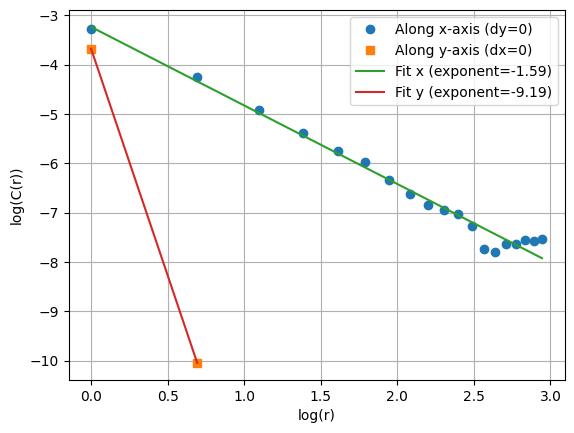

In [ ]:
# Compute the gradient of the log-log plot
from scipy.stats import linregress

# Extract data from the directional cuts
Lx, Ly = corr_2d.shape
cx, cy = Lx // 2, Ly // 2
cut_x = corr_2d[cx:, cy]
r_x = np.arange(0, len(cut_x))
cut_y = corr_2d[cx, cy:]
r_y = np.arange(0, len(cut_y))

# Filter out non-positive correlation values before taking the logarithm
# Along x-axis
positive_mask_x = cut_x[1:] > 0
log_r_x = np.log(r_x[1:][positive_mask_x])
log_cut_x = np.log(cut_x[1:][positive_mask_x])
slope_x, intercept_x, r_value_x, p_value_x, std_err_x = linregress(log_r_x, log_cut_x)

# Along y-axis
positive_mask_y = cut_y[1:] > 0
log_r_y = np.log(r_y[1:][positive_mask_y])
log_cut_y = np.log(cut_y[1:][positive_mask_y])
slope_y, intercept_y, r_value_y, p_value_y, std_err_y = linregress(log_r_y, log_cut_y)

print(f"Power law exponent along x-axis: {slope_x:.4f}")
print(f"Power law exponent along y-axis: {slope_y:.4f}")

# Plot the log-log data with the fitted lines
plt.figure()
plt.plot(log_r_x, log_cut_x, 'o', label='Along x-axis (dy=0)')
plt.plot(log_r_y, log_cut_y, 's', label='Along y-axis (dx=0)')
plt.plot(log_r_x, slope_x * log_r_x + intercept_x, '-', label=f'Fit x (exponent={slope_x:.2f})')
plt.plot(log_r_y, slope_y * log_r_y + intercept_y, '-', label=f'Fit y (exponent={slope_y:.2f})')
plt.xlabel('log(r)'); plt.ylabel('log(C(r))')
plt.legend(); plt.grid(True); plt.show()

Estimated power-law exponent: -1.61


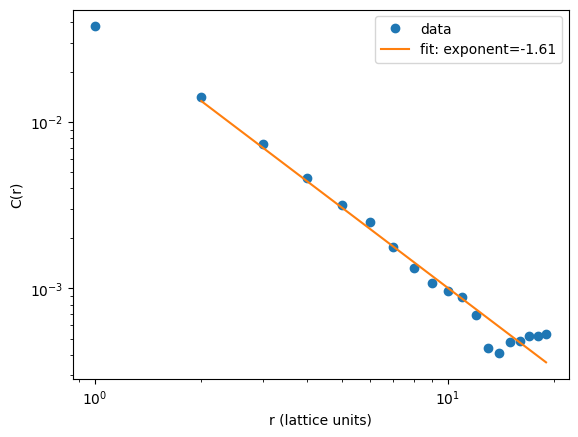

In [ ]:
# Extract data from the directional cuts (assuming corr_2d is available from previous cells)
Lx, Ly = corr_2d.shape
cx, cy = Lx // 2, Ly // 2
cut_x = corr_2d[cx:, cy]
r_x_full = np.arange(0, len(cut_x))
cut_y = corr_2d[cx, cy:]
r_y_full = np.arange(0, len(cut_y))


# Filter out non-positive correlation values
positive_mask_x = cut_x[1:] > 0
r_x_full = r_x_full[1:][positive_mask_x]
cut_x_full = cut_x[1:][positive_mask_x]

positive_mask_y = cut_y[1:] > 0
r_y_full = r_y_full[1:][positive_mask_y]
cut_y_full = cut_y[1:][positive_mask_y]


# Example: r = distances, C = correlation function values
r = r_x_full # use x-axis data for this example
C = cut_x_full # use x-axis data for this example


# --- Select fitting range ---
# Avoid r=0 and noisy tail (you choose depending on your data!)
fit_mask = (r > 1) & (r < 20)   # example: only fit between 1 and 20 lattice units
r_fit = r[fit_mask]
C_fit = C[fit_mask]

# --- Fit in log-log space ---
log_r = np.log(r_fit)
log_C = np.log(C_fit)
coeffs = np.polyfit(log_r, log_C, 1)   # linear fit in log-log space
slope, intercept = coeffs

exponent = slope   # since log(C) ≈ exponent*log(r) + intercept
print(f"Estimated power-law exponent: {exponent:.2f}")

# --- Plot log-log with fit line ---
plt.figure()
plt.loglog(r, C, 'o', label="data")

# Plot fitted line
r_line = np.linspace(min(r_fit), max(r_fit), 100)
C_line = np.exp(intercept) * r_line**slope
plt.loglog(r_line, C_line, '-', label=f"fit: exponent={slope:.2f}")

plt.xlabel("r (lattice units)")
plt.ylabel("C(r)")
plt.legend()
plt.show()

In [ ]:
print(f"R-squared value along x-axis: {r_value_x**2:.4f}")
print(f"R-squared value along y-axis: {r_value_y**2:.4f}")

R-squared value along x-axis: 0.9794
R-squared value along y-axis: 1.0000
